# ***Time Series Analysis Of Truck Sales : Forecasting with SARIMA Models***

## Abstract

In the realm of data-driven decision-making, time series forecasting plays a crucial role in predicting trends and optimizing business strategies. The dataset we will be analyzing originates from Kaggle and consists of monthly truck sales data from a specific company, spanning several years (from January 2003 to December 2014).

This dataset is particularly valuable for developing ARIMA/SARIMA models to forecast future truck sales, making it highly relevant for businesses looking to improve supply chain management, production planning, and market analysis.



## **Key Characteristics of the Dataset**

- Data Source: Kaggle
- Response Variable (Yt): Monthly truck sales (continuous values)
- Time Frame: January 2003 – December 2014
- Sampling Frequency: Monthly
- Total Observations (n): 144 (sufficient for robust time series modeling)
- Missing Data: None


This dataset will serve as an adequate foundation for applying time series analysis techniques learned , exploring trends and forecasting models.

# Phase 0 : Data Loading

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving Truck_sales.csv to Truck_sales.csv


In [ ]:
library(readr)

data<- read_csv("Truck_sales.csv")

head(data)

Rows: 144 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Month-Year
dbl (1): Number_Trucks_Sold

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Month-Year,Number_Trucks_Sold
<chr>,<dbl>
03-Jan,155
03-Feb,173
03-Mar,204
03-Apr,219
03-May,223
03-Jun,208


In [ ]:
colnames(data) #showing the columns names

[1] "Month-Year"         "Number_Trucks_Sold"

In [ ]:
# Load required libraries
library(tidyverse)
library(lubridate)
library(ggplot2)


In [ ]:
install.packages("forecast")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘timeDate’




In [ ]:
install.packages("tseries")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


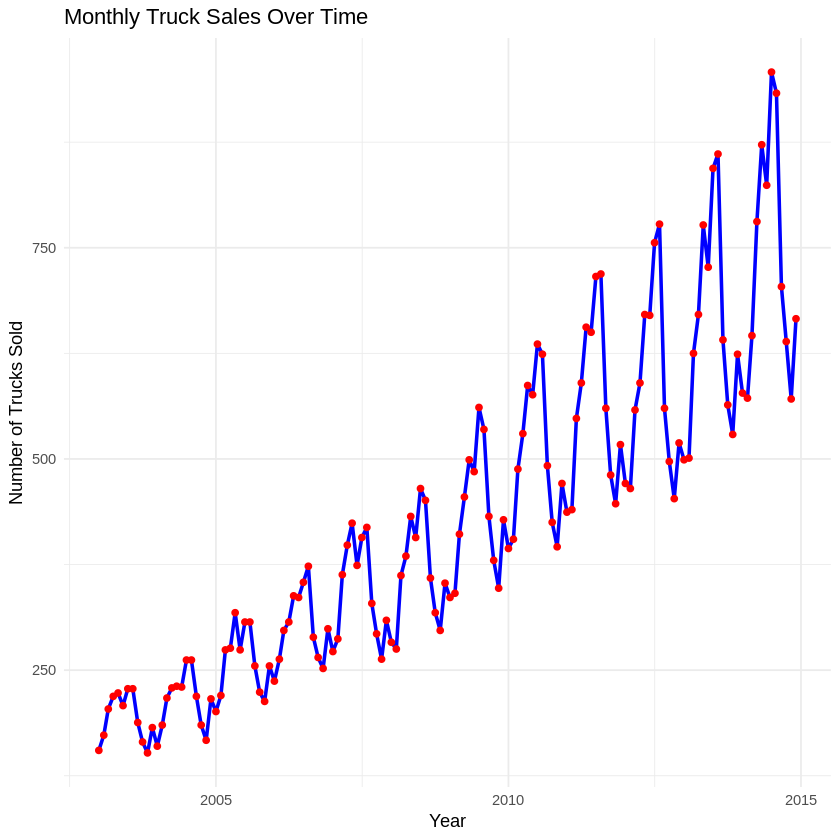

In [ ]:
# Converting mont-year column to a date format
data$Date <- parse_date_time(data$'Month-Year', orders = "ym")

# Time serie object
truck_ts <- ts(data$Number_Trucks_Sold, start=c(2003,1), frequency=12)

# Plot the time series
ggplot(data, aes(x = Date, y = Number_Trucks_Sold)) +
  geom_line(color = "blue", size = 1) +
  geom_point(color = "red") +
  theme_minimal() +
  labs(title = "Monthly Truck Sales Over Time",
       x = "Year",
       y = "Number of Trucks Sold")

**observation about the plot**


*   Upward Trend : there is a clear increasing trend over time , which means trucks sales have been rising (for the company , this indicates growth in demand for the trucks)
*  Seasonality : we can clearly tell that the pattern appears to e repeatitive each 12 months , with peaks in certain months-jul/aug- (this for the company indicates seasonal demand variation changes, so in certain months the trucks are demanded more )


*   Increasing variability : the fluctuations of the data is increasing as time is passing (suggests heteroscedasticity) which means we need to apply a transforrmation to stabilize variance


# Phase 01 : variance stabilisation and differencing

### Decomposition of the timeserie

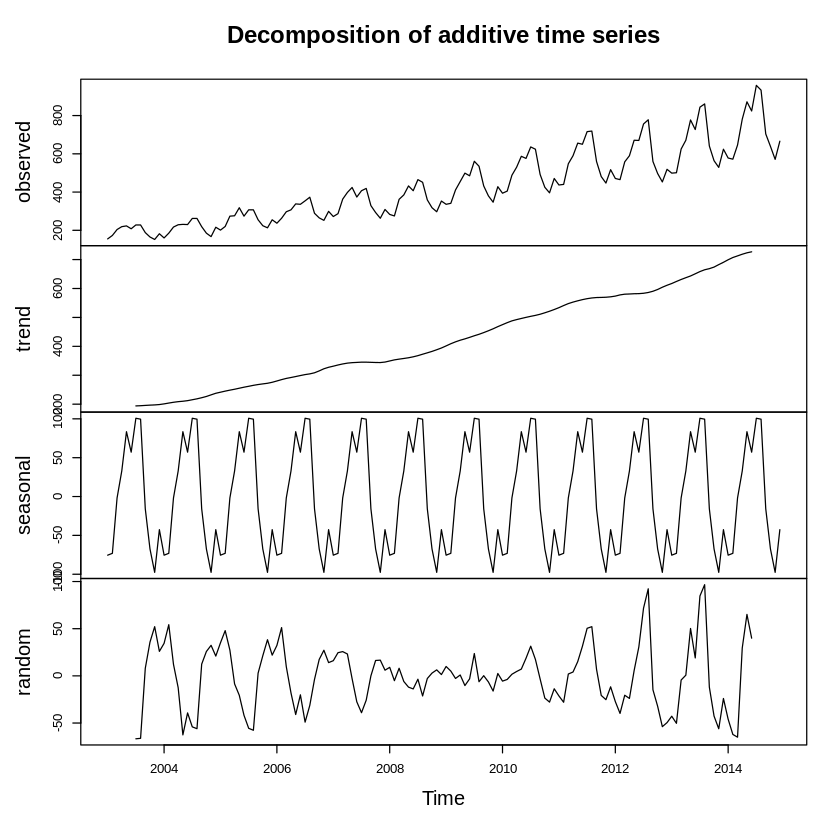

In [ ]:
library(forecast)

decomposed_ts <- decompose(truck_ts)

plot(decomposed_ts)

Key observations
- The series is clearly non-stationary, requiring differencing before applying models
- The strong seasonal component supports the use of SARIMA or other seasonal models.
- Residuals should be examined  to ensure they behave like white noise

In [ ]:
findfrequency(truck_ts)

[1] 12


### variance stabilization

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



[1] 0.2606036


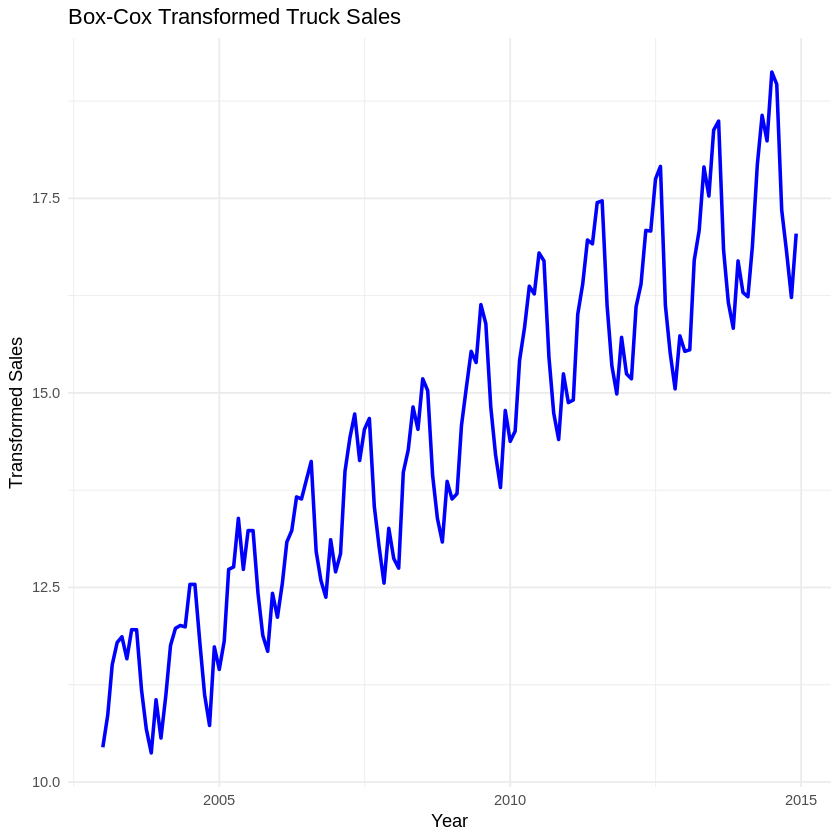

In [ ]:
#using BoxCox transformation
library(forecast)

lambda <- BoxCox.lambda(data$Number_Trucks_Sold)
print(lambda)  # Best transformation power

data$BoxCox_Sales <- BoxCox(data$Number_Trucks_Sold, lambda)

ggplot(data, aes(x = Date, y = BoxCox_Sales)) +
  geom_line(color = "blue", size = 1) +
  theme_minimal() +
  labs(title = "Box-Cox Transformed Truck Sales",
       x = "Year",
       y = "Transformed Sales")

### ADF and KPSS tests

In [ ]:
library(tseries)

# ADF Test is a test we apply to check stationarity
adf_test <- adf.test(data$BoxCox_Sales)
print(adf_test)

# KPSS Test is a test we apply to check stationarity
kpss_test <- kpss.test(data$BoxCox_Sales)
print(kpss_test)


Warning message in adf.test(data$BoxCox_Sales):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  data$BoxCox_Sales
Dickey-Fuller = -15.312, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary



Warning message in kpss.test(data$BoxCox_Sales):
“p-value smaller than printed p-value”



	KPSS Test for Level Stationarity

data:  data$BoxCox_Sales
KPSS Level = 2.7358, Truncation lag parameter = 4, p-value = 0.01



**interpretation**

**ADF Test:** **Dickey-Fuller Test**

  p-value = 0.01 (which is ≤ 0.05)

  Conclusion: Data is stationary

**KPSS Test :Kwiatkowski–Phillips–Schmidt–Shin**

  p-value = 0.01 (which is < 0.05)

  Conclusion: Data has a trend(is not stationary)

 What Does This Mean?
   ADF says "stationary"

  KPSS says "there is a trend"

since the tests disagree we will apply first order differencing to the data , to remove the trend

### First Order Differencing

In [ ]:
data$Diff_BoxCox_Sales <- c(NA, diff(data$BoxCox_Sales, differences = 1))#added a null val cuz we will be having a loss of one line

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


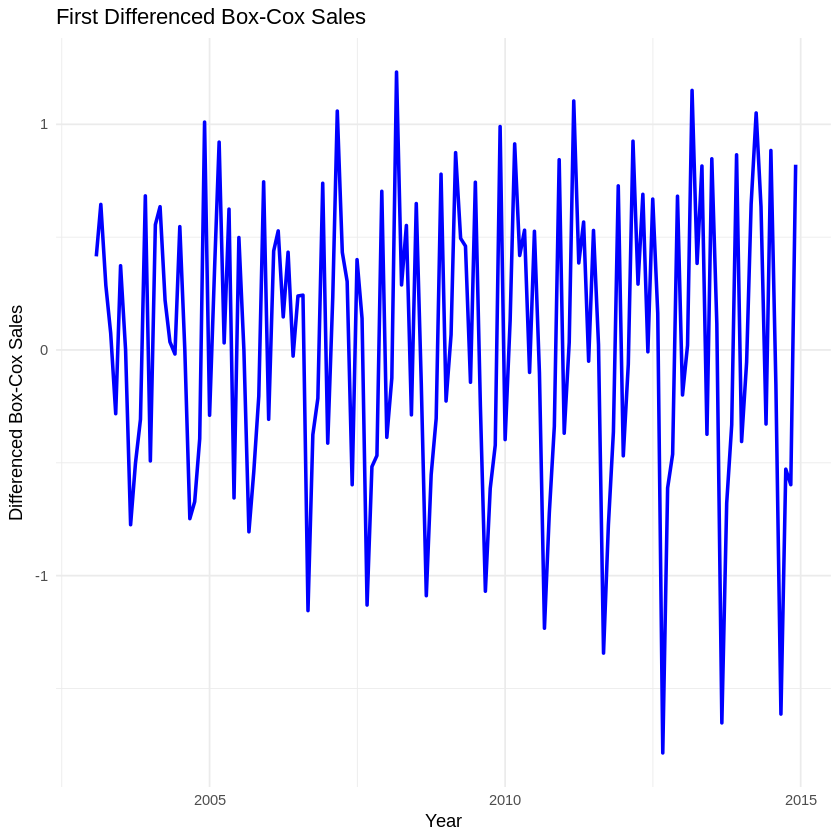

In [ ]:
ggplot(data, aes(x = Date, y = Diff_BoxCox_Sales)) +
  geom_line(color = "blue", size = 1) +
  theme_minimal() +
  labs(title = "First Differenced Box-Cox Sales",
       x = "Year",
       y = "Differenced Box-Cox Sales")


ADF KPSS Tests

In [ ]:
# Remove NA values before testing
diff_data <- na.omit(data$Diff_BoxCox_Sales)

# ADF Test
adf_test_diff <- adf.test(diff_data)
print(adf_test_diff)

# KPSS Test
kpss_test_diff <- kpss.test(diff_data, null = "Level")
print(kpss_test_diff)



Warning message in adf.test(diff_data):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  diff_data
Dickey-Fuller = -16.074, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary



Warning message in kpss.test(diff_data, null = "Level"):
“p-value greater than printed p-value”



	KPSS Test for Level Stationarity

data:  diff_data
KPSS Level = 0.018518, Truncation lag parameter = 4, p-value = 0.1



**interpretation :**
 stationarity is achieved


ACF PACF plots


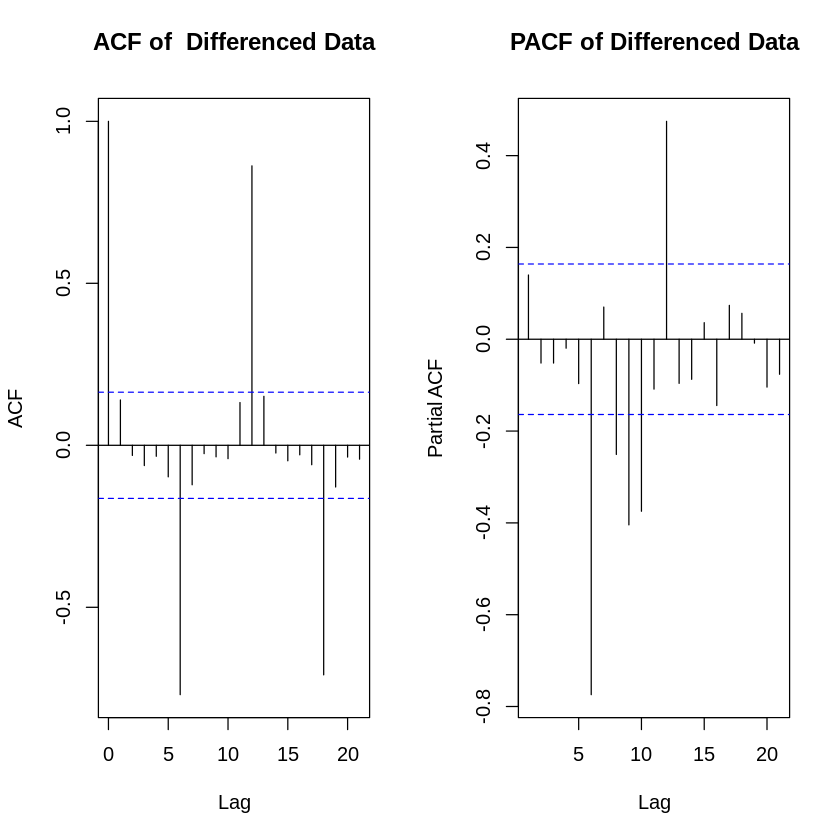

In [ ]:
# ACF & PACF plots for  differenced data
library(forecast)
par(mfrow = c(1, 2))
acf(diff_data, main = "ACF of Differenced Data")
pacf(diff_data, main = "PACF of Differenced Data")


**Interpretation:**

The presence of seasonal spikes in ACF means that first-order differencing alone is not enough to remove seasonality.

This suggests that seasonal differencing is necessary to achieve full stationarit

### Sesonal Differencing

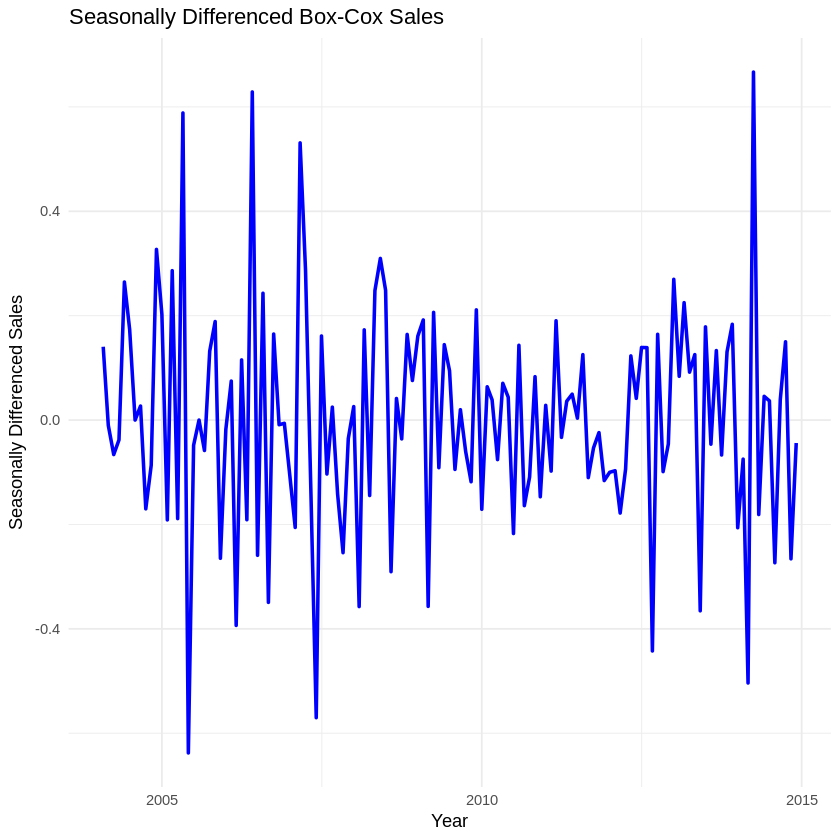

In [ ]:
# Apply seasonal differencing

seasonal_diff_data <- diff(diff_data, lag = 12, differences = 1)  # First seasonal differencing

# Trim the Date column to match
date_seasonal_aligned <- tail(date_aligned, length(seasonal_diff_data))

# Create a dataframe
seasonal_df <- data.frame(
  Date = date_seasonal_aligned,
  Seasonal_Differenced_Sales = seasonal_diff_data
)

# Plot the seasonally differenced data
ggplot(seasonal_df, aes(x = Date, y = Seasonal_Differenced_Sales)) +
  geom_line(color = "blue", size = 1) +
  theme_minimal() +
  labs(title = "Seasonally Differenced Box-Cox Sales",
       x = "Year",
       y = "Seasonally Differenced Sales")


ADF KPSS Tests

In [ ]:
adf.test(seasonal_diff_data)  # ADF Test
kpss.test(seasonal_diff_data, null = "Level")  # KPSS Test


Warning message in adf.test(seasonal_diff_data):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  seasonal_diff_data
Dickey-Fuller = -5.0978, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


Warning message in kpss.test(seasonal_diff_data, null = "Level"):
“p-value greater than printed p-value”



	KPSS Test for Level Stationarity

data:  seasonal_diff_data
KPSS Level = 0.074753, Truncation lag parameter = 4, p-value = 0.1


**Interpretation:**

Since ACF no longer exhibits strong seasonal patterns, the seasonal differencing was successful.

This dataset is now more appropriate for SARIMA modeling.

ACF PACF Plots

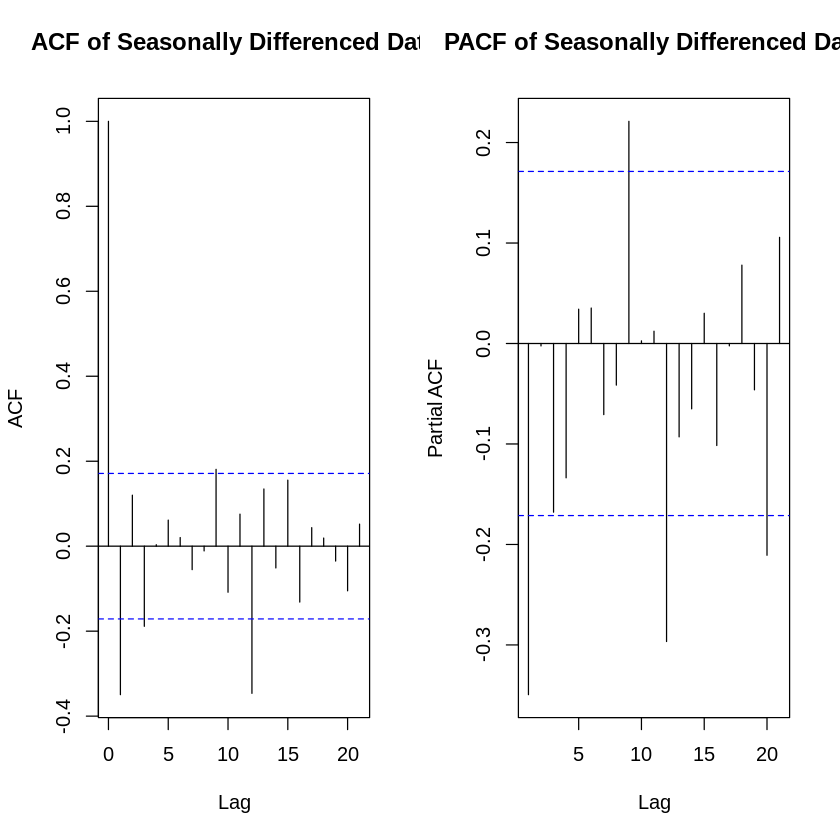

In [ ]:
# ACF & PACF plots for seasonally differenced data
library(forecast)
par(mfrow = c(1, 2))  # Arrange plots side by side
acf(seasonal_diff_data, main = "ACF of Seasonally Differenced Data")
pacf(seasonal_diff_data, main = "PACF of Seasonally Differenced Data")


**interpretation of ACF and PACF plots**

we aim to determine sarima parameters so we can apply the model on the data

*Defining Differencing Parameters (d, D, s)*

*   d (non-seasonal differencing): Since we applied first-order differencing and achieved stationarity, we set d = 1.

*   D (seasonal differencing): Since we also applied one seasonal differencing step, we set D = 1.


*   s (seasonal period): Since the data is monthly truck sales, the seasonal period is s = 12 .


*Defining Non-Seasonal Parameters (p, q)*
PACF Analysis:

  The PACF shows a sharp cutoff at lag 1 which  suggests that p=1 (AR(1))

ACF Analysis:

The ACF shows gradual decay after lag 1, which is characteristic of an AR process rather than an MA process.

However, there might be a slight spike at lag 1, suggesting that an MA(1) component could also be considered.

**Possible values for q: 0 or 1.**

Possible Choices for (p, q):
(1, 0) → AR(1) model

(1, 1) → ARMA(1,1) model


---

*Defining Seasonal Parameters (P, Q)*

PACF Analysis:

  A significant spike at lag 12, indicating a seasonal AR term (P = 1).

ACF Analysis:

  A significant spike at lag 12, suggesting a seasonal MA term (Q = 1).

**Possible Choices for (P, Q):**

(1, 0) → Seasonal AR(1)

(1, 1) → Seasonal ARMA(1,1)


---

**Final Suggested SARIMA Models **

 - SARIMA(1,1,0) × (1,1,0,12) : If the MA term is not significant
 - SARIMA(1,1,1) × (1,1,0,12) : If a non-seasonal MA term is helpful
 - SARIMA(1,1,1) × (1,1,1,12) : If both seasonal AR and MA are needed
 - SARIMA(1,1,0) × (1,1,1,12) : If a seasonal MA term is more dominant




# Phase 02 : Estimation of parameters and potential models

### fitting the possible models and choosing the most appropriate one

In [ ]:
# Model 1: SARIMA(1,1,0) × (1,1,0,12)
model1 <- Arima(data$Number_Trucks_Sold, order = c(1,1,0), seasonal = c(1,1,0), method = "ML")

# Model 2: SARIMA(1,1,1) × (1,1,0,12)
model2 <- Arima(data$Number_Trucks_Sold, order = c(1,1,1), seasonal = c(1,1,0), method = "ML")

# Model 3: SARIMA(1,1,1) × (1,1,1,12)
model3 <- Arima(data$Number_Trucks_Sold, order = c(1,1,1), seasonal = c(1,1,1), method = "ML")

# Model 4: SARIMA(1,1,0) × (1,1,1,12)
model4 <- Arima(data$Number_Trucks_Sold, order = c(1,1,0), seasonal = c(1,1,1), method = "ML")


In [ ]:
# Function to extract model metrics
get_model_summary <- function(model) {
  return(data.frame(
    AIC = AIC(model),
    BIC = BIC(model),
    LogLik = logLik(model),
    RMSE = accuracy(model)[2]  # RMSE value from model accuracy
  ))
}

# Create a dataframe to compare models
model_comparison <- data.frame(
  Model = c("SARIMA(1,1,0) × (1,1,0,12)",
            "SARIMA(1,1,1) × (1,1,0,12)",
            "SARIMA(1,1,1) × (1,1,1,12)",
            "SARIMA(1,1,0) × (1,1,1,12)")
)

# Extract the metrics for each model
model_comparison <- cbind(model_comparison,
                          rbind(get_model_summary(model1),
                                get_model_summary(model2),
                                get_model_summary(model3),
                                get_model_summary(model4)))


print(model_comparison)


                       Model      AIC      BIC    LogLik     RMSE
1 SARIMA(1,1,0) × (1,1,0,12) 1588.578 1594.504 -792.2890 61.43402
2 SARIMA(1,1,1) × (1,1,0,12) 1576.452 1585.340 -785.2259 58.30091
3 SARIMA(1,1,1) × (1,1,1,12) 1576.452 1585.340 -785.2259 58.30091
4 SARIMA(1,1,0) × (1,1,1,12) 1588.578 1594.504 -792.2890 61.43402


**interpretation**
To determine the best model , we should look at the metrics :

- AIC (Akaike Information Criterion) : the lower the better

- BIC (Bayesian Information Criterion) : the lower the better

- Log-Likelihood : the higher the better

- RMSE (Root Mean Squared Error) : the lower the better


---

Analysis of the result
we canclearly see that the two models 2 and 3 have the same results,  the lowest AIC and BIC and RMSE, highest log-likelihood  , making them the two best models .
we shall now check their residuals


### Residuals Analysis

notice : we will be evaluating the residuals of only model 2 since their results are aparently the exact same


	Ljung-Box test

data:  Residuals from ARIMA(1,1,1)
Q* = 68.292, df = 8, p-value = 1.074e-11

Model df: 2.   Total lags used: 10



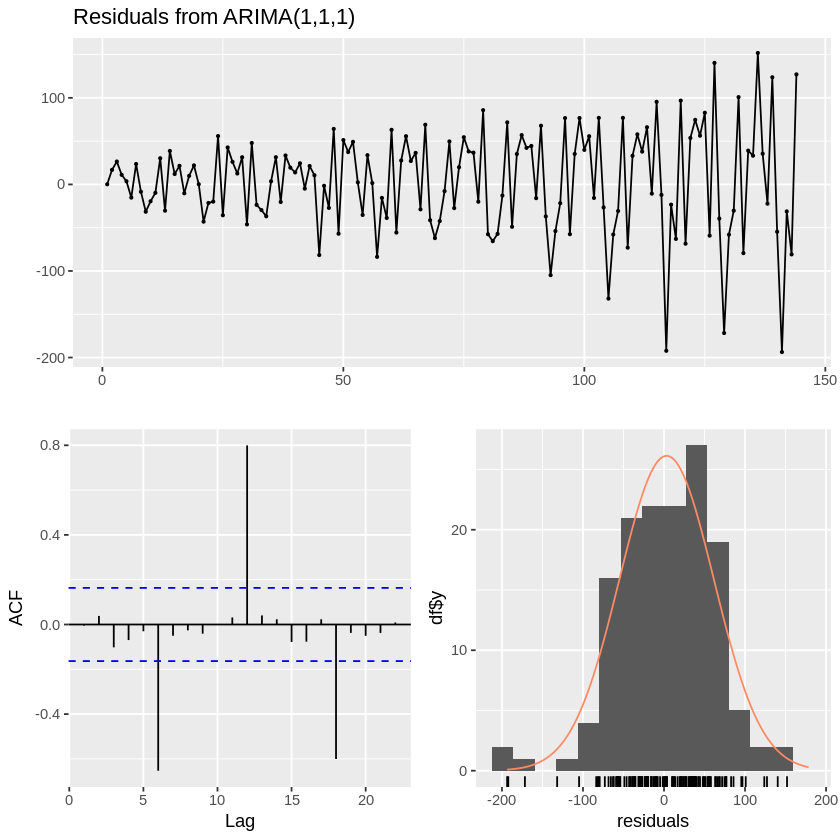

In [ ]:
#checking the residuals of model 2
checkresiduals(model2)

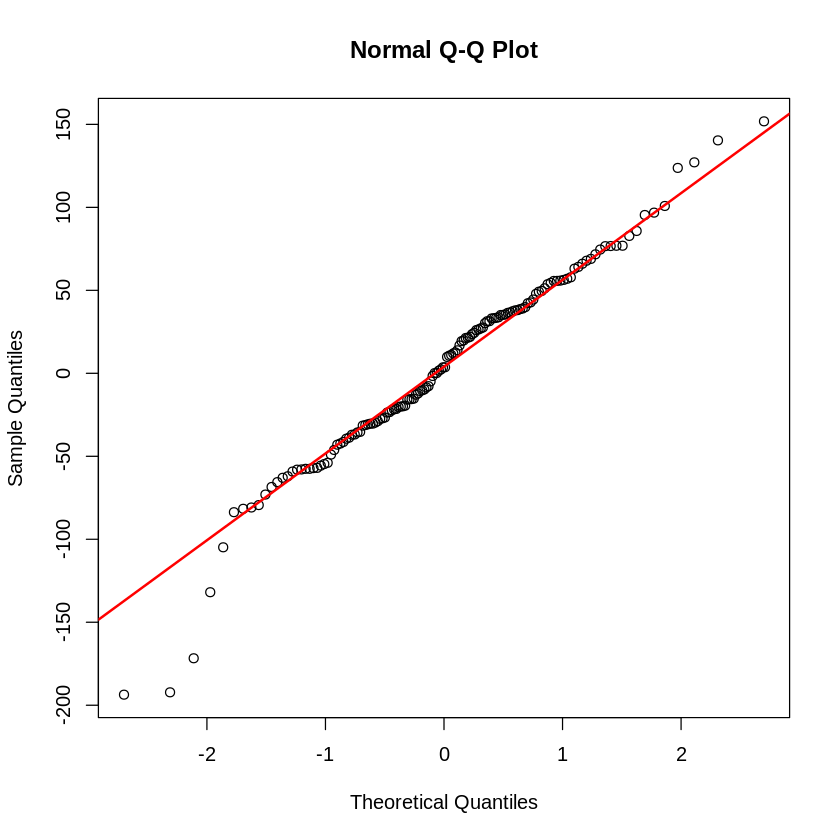

In [ ]:
qqnorm(residuals(model2))
qqline(residuals(model2), col = "red", lwd = 2)

In [ ]:
shapiro.test(residuals(model2))


	Shapiro-Wilk normality test

data:  residuals(mol2)
W = 0.97429, p-value = 0.008205


**Interpretation of Model 02**

***Ljung-Box test***
- The test checks if residuals are autocorrelated. p-value = 1.074e-11 (very small).

- A small p-value indicates that residuals are not independent—meaning the model may not have fully captured the time dependence.

- Residuals seem randomly distributed around zero, which is good but there are visble spikes , means some patterns are still present

- The autocorrelation function (ACF) should ideally show no significant spikes outside the blue confidence bands if we assume the residuals are white noise , but we can see some spikes so it is not the case

- The histogram should ideally resemble a normal distribution.

- The red density curve suggests a slightly non-normal distribution, but it is not heavily skewed.

- The Q-Q plot compares the quantiles of residuals against a normal distribution.while most points lie on the red line we can see deviation at the tails , indicating non-normality


***Shapiro-Wilk Test for Normality***

p-value = 0.008205.

Since p < 0.05 then the residuals are not normal

**Conclusion:**

Model 2 is decent but not perfect.

There is some remaining autocorrelation in residuals, and they are not perfectly normal.


.......................................................................................................................................................................

To improve our model , we will try to redifference our data and see wt we can have

# Phase 01 and 02 (Round 02 )

## Second Order Differencing

In [ ]:
data$Diff2_BoxCox_Sales <- c(NA, diff(data$Diff_BoxCox_Sales, differences = 1))


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_line()`).”


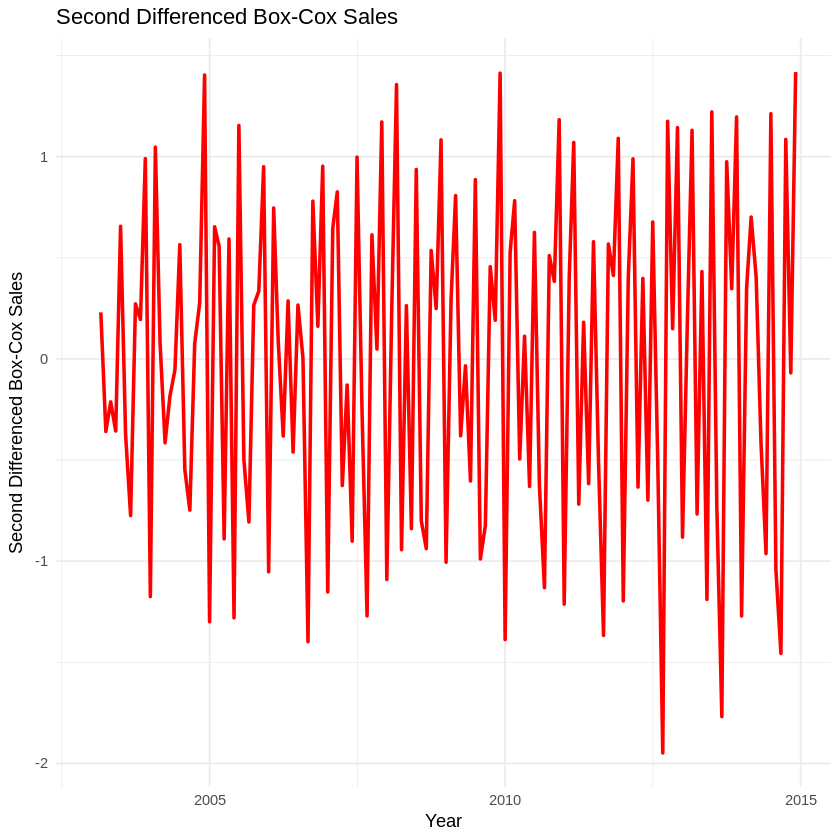

In [ ]:
ggplot(data, aes(x = Date, y = Diff2_BoxCox_Sales)) +
  geom_line(color = "red", size = 1) +
  theme_minimal() +
  labs(title = "Second Differenced Box-Cox Sales",
       x = "Year",
       y = "Second Differenced Box-Cox Sales")


**interpretation**
we tried to apply second differencing to check if there is still trend or seasonality in the data


ADF KPSS Tests

In [ ]:
# Remove NAs from the second differenced data
diff2_clean <- na.omit(data$Diff2_BoxCox_Sales)

# Augmented Dickey-Fuller Test for stationarity of the timeserie
adf_result <- adf.test(diff2_clean, alternative = "stationary")

# KPSS Test for stationarity of timeserie
kpss_result <- kpss.test(diff2_clean, null = "Level")

print(adf_result)
print(kpss_result)


Warning message in adf.test(diff2_clean, alternative = "stationary"):
“p-value smaller than printed p-value”
Warning message in kpss.test(diff2_clean, null = "Level"):
“p-value greater than printed p-value”



	Augmented Dickey-Fuller Test

data:  diff2_clean
Dickey-Fuller = -9.3816, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


	KPSS Test for Level Stationarity

data:  diff2_clean
KPSS Level = 0.028604, Truncation lag parameter = 4, p-value = 0.1



**interpretation**

The results from both tests confirm that the second-order differenced series is stationary. This validates the preprocessing step, making the data suitable for SARIMA modeling.

ACF PACF Plots

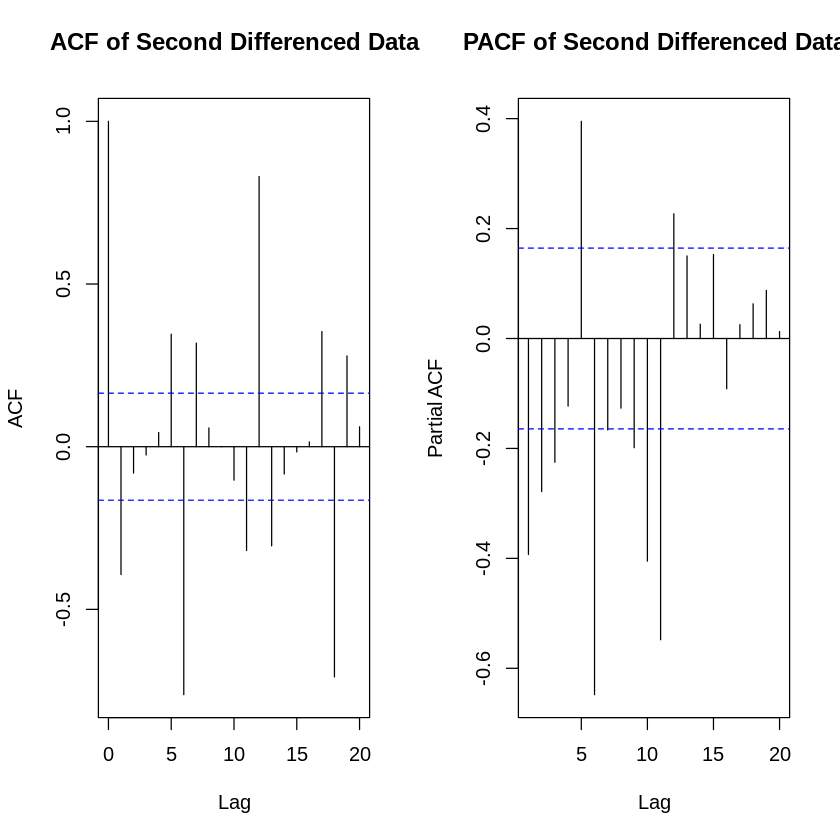

In [ ]:

library(ggplot2)
library(forecast)

# Ensure the second-differenced data is free of NAs(same in first order)
diff2_clean <- na.omit(data$Diff2_BoxCox_Sales)

# ACF and PACF plots
par(mfrow = c(1, 2))

# ACF plot
acf(diff2_clean, main = "ACF of Second Differenced Data", lag.max = 20)

# PACF plot
pacf(diff2_clean, main = "PACF of Second Differenced Data", lag.max = 20)


par(mfrow = c(1, 1))


**interpretation**
based on the plots analysis we will be trying to analyze some SARIMA models options , we will try :
- SARIMA(2,2,2) × (1,1,1,12)
- SARIMA(1,2,1) × (1,1,1,12)
- SARIMA(3,2,2) × (1,1,1,12)
- SARIMA(2,2,1) × (1,1,1,12)
- SARIMA(1,2,2) × (1,1,1,12)



Getting Models Summary


In [ ]:
library(forecast)

# Function to extract model metrics
get_model_summary <- function(model) {
  return(data.frame(
    AIC = AIC(model),
    BIC = BIC(model),
    LogLik = as.numeric(logLik(model)),
    RMSE = accuracy(model)[2]  # RMSE value from model accuracy
  ))
}

# Fit multiple SARIMA models
model1 <- Arima(data$BoxCox_Sales, order=c(2,2,2), seasonal=list(order=c(1,1,1), period=12))
model2 <- Arima(data$BoxCox_Sales, order=c(1,2,1), seasonal=list(order=c(1,1,1), period=12))
model3 <- Arima(data$BoxCox_Sales, order=c(3,2,2), seasonal=list(order=c(1,1,1), period=12))
model4 <- Arima(data$BoxCox_Sales, order=c(2,2,1), seasonal=list(order=c(1,1,1), period=12))
model5 <- Arima(data$BoxCox_Sales, order=c(1,2,2), seasonal=list(order=c(1,1,1), period=12))

# Create a dataframe to compare models
model_comparison <- data.frame(
  Model = c("SARIMA(2,2,2) × (1,1,1,12)",
            "SARIMA(1,2,1) × (1,1,1,12)",
            "SARIMA(3,2,2) × (1,1,1,12)",
            "SARIMA(2,2,1) × (1,1,1,12)",
            "SARIMA(1,2,2) × (1,1,1,12)")
)

# Extract the metrics for each model
model_comparison <- cbind(model_comparison,
                          rbind(get_model_summary(model1),
                                get_model_summary(model2),
                                get_model_summary(model3),
                                get_model_summary(model4),
                                get_model_summary(model5)))

# Print model comparison table
print(model_comparison)


                       Model       AIC       BIC   LogLik      RMSE
1 SARIMA(2,2,2) × (1,1,1,12) -49.13923 -29.06649 31.56962 0.1689228
2 SARIMA(1,2,1) × (1,1,1,12) -49.45901 -35.12133 29.72950 0.1729260
3 SARIMA(3,2,2) × (1,1,1,12) -47.14400 -24.20372 31.57200 0.1689184
4 SARIMA(2,2,1) × (1,1,1,12) -47.80850 -30.60330 29.90425 0.1725891
5 SARIMA(1,2,2) × (1,1,1,12) -48.40531 -31.20010 30.20266 0.1720858


**interpretation**

if we prioritize forcasting , we would choose SARIMA(2,2,2) × (1,1,1,12) because it has  the lowest RMSE (0.1689) (we chose it over SARIMA(3,2,2) × (1,1,1,12) because the latter has a larger AIC)

summary and residuals of model1 :SARIMA(2,2,2) × (1,1,1,12)

In [ ]:
model_test <- Arima(data$BoxCox_Sales, order = c(2,2,2), seasonal = c(1,1,1,12))
summary(model_test)


Series: data$BoxCox_Sales 
ARIMA(2,2,2) 

Coefficients:
         ar1      ar2      ma1     ma2
      0.9660  -0.3296  -1.9978  1.0000
s.e.  0.0792   0.0797   0.0288  0.0287

sigma^2 = 0.3123:  log likelihood = -122.65
AIC=255.3   AICc=255.74   BIC=270.08

Training set error measures:
                      ME      RMSE       MAE        MPE     MAPE      MASE
Training set -0.02359619 0.5470753 0.4585369 -0.2899004 3.195066 0.8880049
                   ACF1
Training set -0.0748581


	Ljung-Box test

data:  Residuals from ARIMA(2,2,2)
Q* = 93.74, df = 6, p-value < 2.2e-16

Model df: 4.   Total lags used: 10



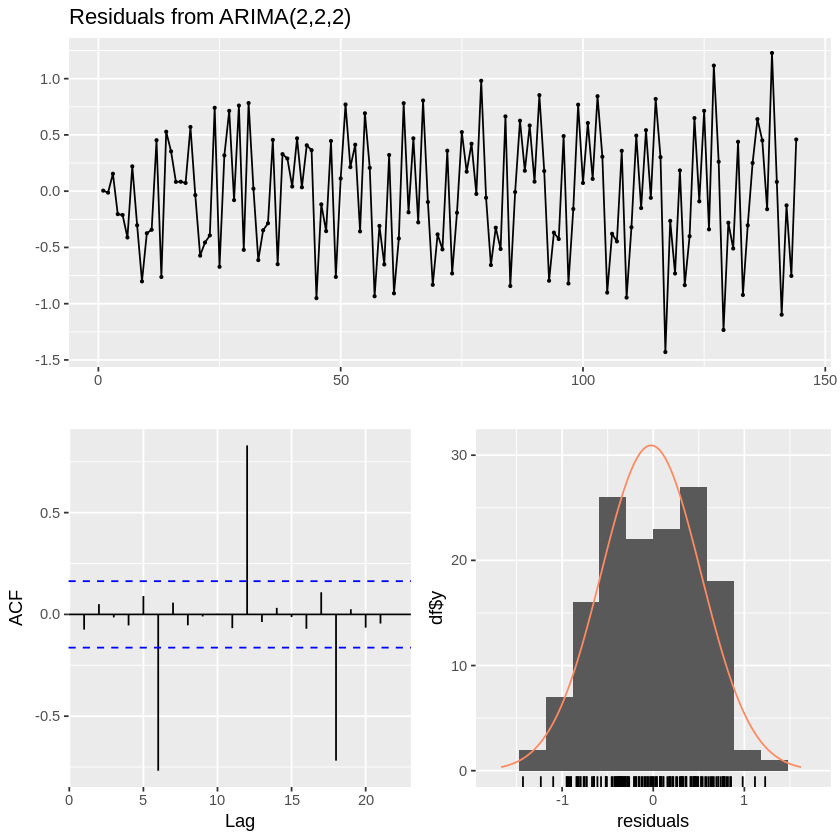

In [ ]:
checkresiduals(model_test)


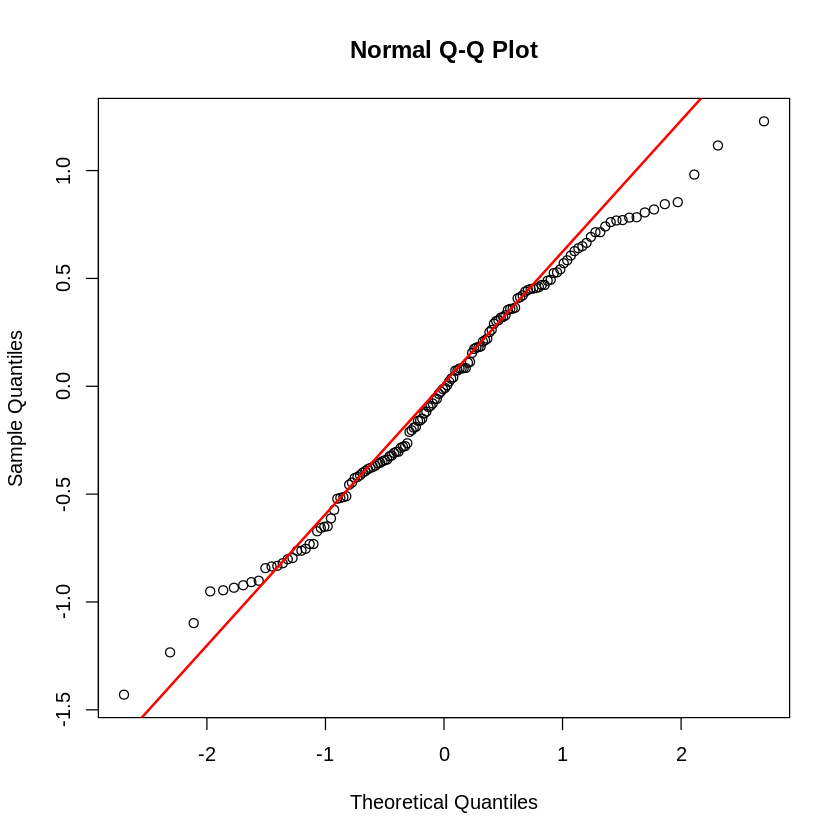

In [ ]:
qqnorm(residuals(model_test))
qqline(residuals(model_test), col = "red", lwd = 2)

In [ ]:
shapiro.test(residuals(model_test))



	Shapiro-Wilk normality test

data:  residuals(model_test)
W = 0.98623, p-value = 0.1616


**interpretation**

from the test , the p-value here is larger than 0.05 and that indicates that the residuals are normally distributed


# Phase 03: Forecasting

in this section we will try to forcast future data using two models we have seen which are **SARIMA(2,2,2) × (1,1,1,12)** and  **SARIMA(1,1,1) × (1,1,0,12)** . we will compare the results and see for ourselves which of the models forcast better

Series: data$Number_Trucks_Sold 
ARIMA(1,1,1)(1,1,0)[12] 

Coefficients:
          ar1      ma1     sar1
      -0.0998  -0.2015  -0.0997
s.e.   0.8616   0.8837   0.0975

sigma^2 = 369.3:  log likelihood = -571.67
AIC=1151.34   AICc=1151.66   BIC=1162.84

Training set error measures:
                    ME    RMSE      MAE         MPE     MAPE      MASE
Training set 0.4482106 18.1171 13.22754 -0.03676769 3.068689 0.2842282
                      ACF1
Training set -0.0004503013


	Ljung-Box test

data:  Residuals from ARIMA(1,1,1)(1,1,0)[12]
Q* = 12.929, df = 7, p-value = 0.07386

Model df: 3.   Total lags used: 10



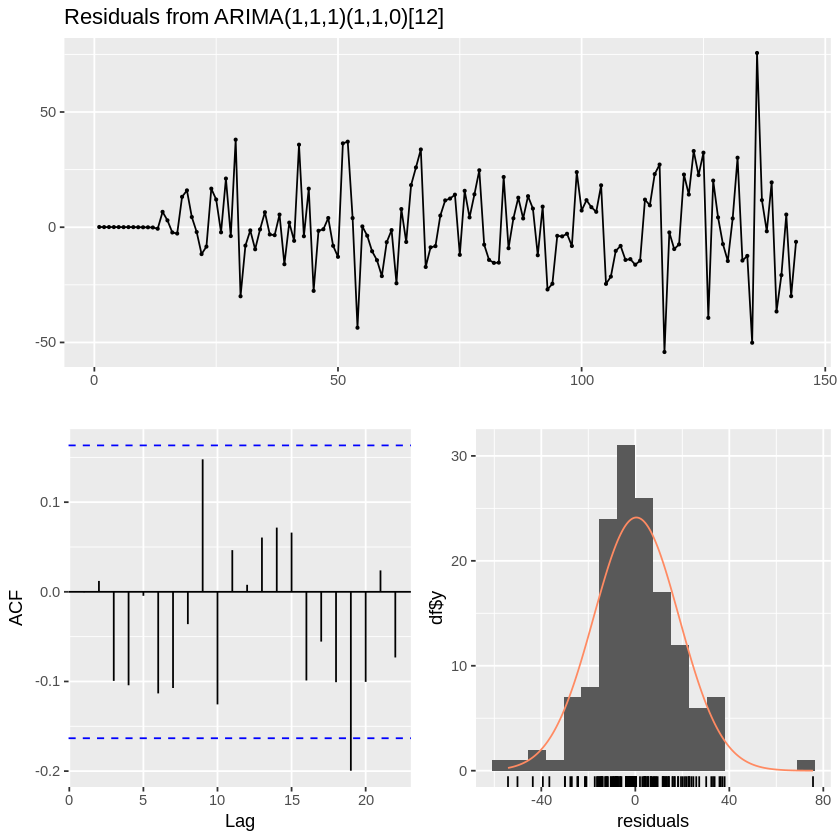

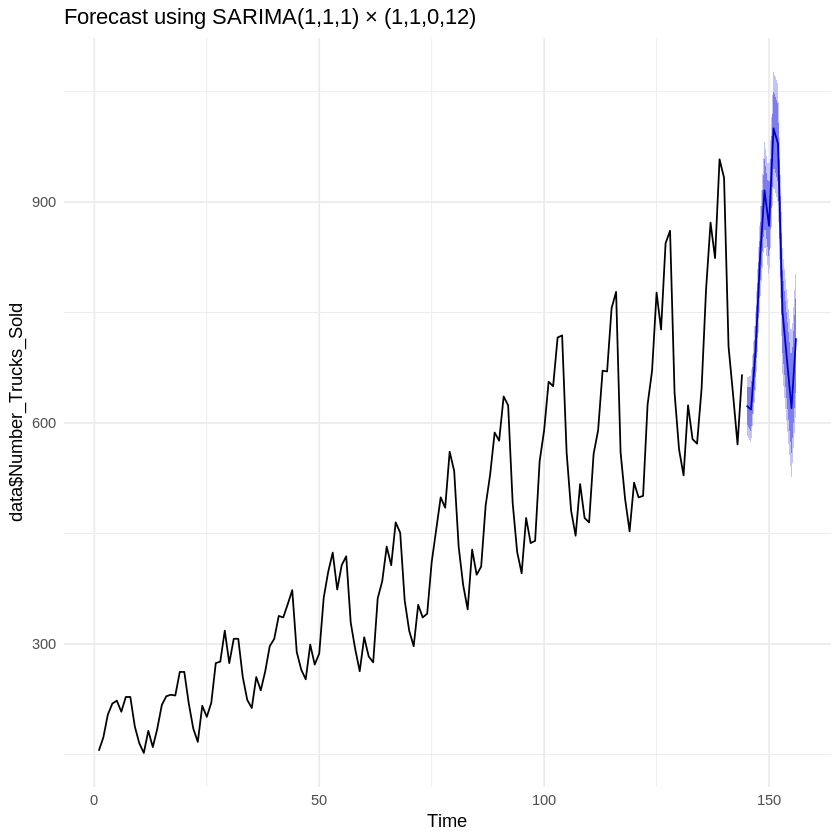

In [ ]:
# Fit SARIMA(1,1,1) × (1,1,0,12) model

library(forecast)
sarima_model <- Arima(data$Number_Trucks_Sold,
                      order = c(1,1,1),
                      seasonal = list(order = c(1,1,0), period = 12))

# Summary of the model
summary(sarima_model)

# Check residuals
checkresiduals(sarima_model)

# Forecast for 12 months ahead
sarima_forecast <- forecast(sarima_model, h = 12)

# Plot forecast
autoplot(sarima_forecast) +
  ggtitle("Forecast using SARIMA(1,1,1) × (1,1,0,12)") +
  theme_minimal()


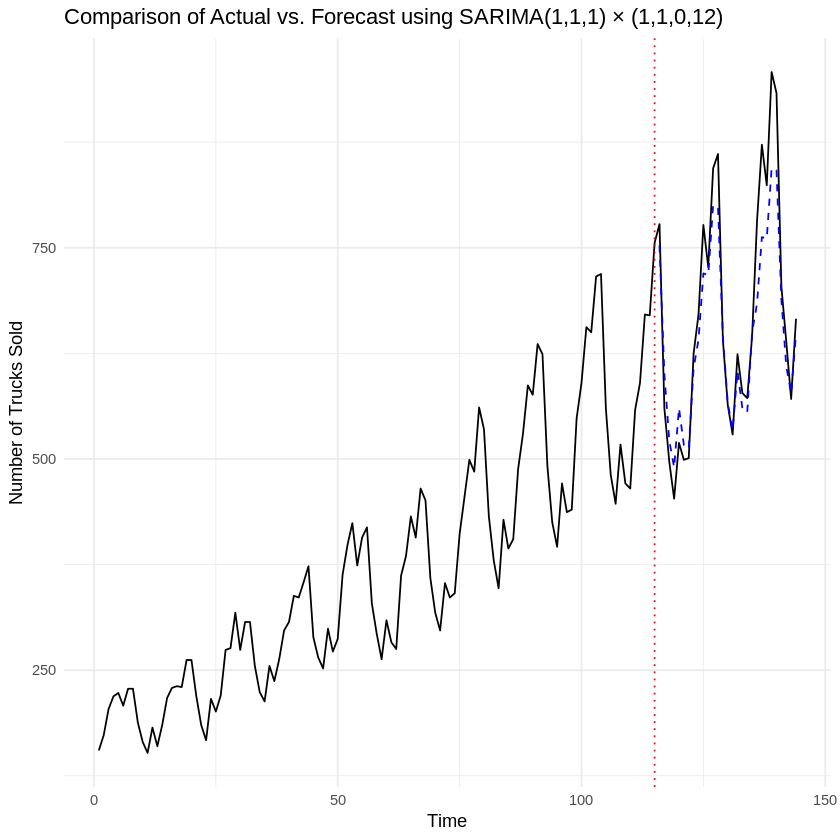

In [ ]:
# Load necessary libraries
library(forecast)
library(ggplot2)

# Define train-test split (80% train, 20% test)
train_size <- floor(0.8 * length(data$Number_Trucks_Sold))
train_data <- data$Number_Trucks_Sold[1:train_size]
test_data <- data$Number_Trucks_Sold[(train_size + 1):length(data$Number_Trucks_Sold)]

# Fit SARIMA(1,1,1) × (1,1,0,12) model
sarima_model <- Arima(train_data, order = c(1,1,1), seasonal = list(order = c(1,1,0), period = 12))

# Forecast for test period
sarima_forecast <- forecast(sarima_model, h = length(test_data))

# Create a dataframe for plotting
forecast_df <- data.frame(
  Time = (train_size + 1):length(data$Number_Trucks_Sold),
  Actual = test_data,
  Forecast = sarima_forecast$mean
)

# Plot comparison of actual vs. forecast
ggplot() +
  geom_line(aes(x = 1:length(data$Number_Trucks_Sold), y = data$Number_Trucks_Sold), color = "black") + # Actual data
  geom_line(aes(x = forecast_df$Time, y = forecast_df$Forecast), color = "blue", linetype = "dashed") + # Forecast
  geom_vline(xintercept = train_size, linetype = "dotted", color = "red") + # Mark training/testing split
  labs(title = "Comparison of Actual vs. Forecast using SARIMA(1,1,1) × (1,1,0,12)",
       x = "Time",
       y = "Number of Trucks Sold") +
  theme_minimal()


In [ ]:
model_test <- Arima(data$BoxCox_Sales, order = c(2,2,2), seasonal = list(order = c(1,1,1), period = 12))


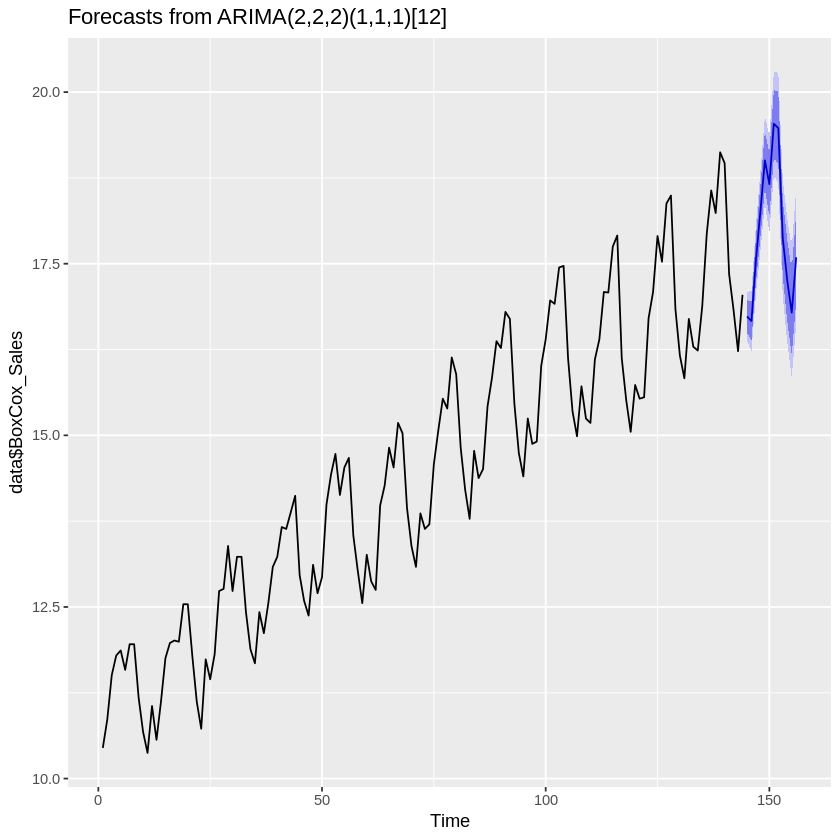

In [ ]:
forecasted_values <- forecast(model_test, h=12)
autoplot(forecasted_values)


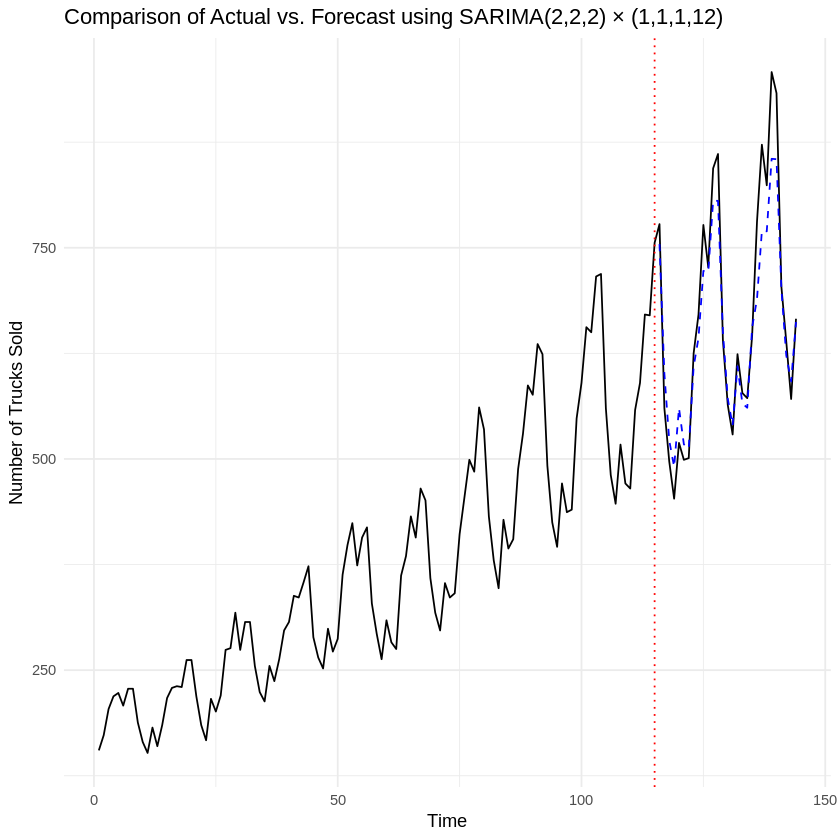

In [ ]:
# Load necessary libraries
library(forecast)
library(ggplot2)

# Define train-test split (80% train, 20% test)
train_size <- floor(0.8 * length(data$Number_Trucks_Sold))
train_data <- data$Number_Trucks_Sold[1:train_size]
test_data <- data$Number_Trucks_Sold[(train_size + 1):length(data$Number_Trucks_Sold)]

# Fit SARIMA(2,2,2) × (1,1,1,12) model
sarima_model <- Arima(train_data, order = c(2,2,2), seasonal = list(order = c(1,1,1), period = 12))

# Forecast for test period
sarima_forecast <- forecast(sarima_model, h = length(test_data))

# Create a dataframe for plotting
forecast_df <- data.frame(
  Time = (train_size + 1):length(data$Number_Trucks_Sold),
  Actual = test_data,
  Forecast = sarima_forecast$mean
)

# Plot comparison of actual vs. forecast
ggplot() +
  geom_line(aes(x = 1:length(data$Number_Trucks_Sold), y = data$Number_Trucks_Sold), color = "black") + # Actual data
  geom_line(aes(x = forecast_df$Time, y = forecast_df$Forecast), color = "blue", linetype = "dashed") + # Forecast
  geom_vline(xintercept = train_size, linetype = "dotted", color = "red") + # Mark training/testing split
  labs(title = "Comparison of Actual vs. Forecast using SARIMA(2,2,2) × (1,1,1,12)",
       x = "Time",
       y = "Number of Trucks Sold") +
  theme_minimal()


**interpretation**

We can clearly see that both models gave very similar forecasting results even tho the SARIMA(1,1,1) × (1,1,0,12 ) residuals are not normally distributed , so to explain why is that , we have some possibilities:


1. Over-Differencing Might Be Leading to Similar Models: If the data was already stationary after first-order differencing, applying a second-order difference might not add much information.


2. The Additional Parameters Aren’t Contributing Much: Even though SARIMA(2,2,2) × (1,1,1,12) has more parameters than SARIMA(1,1,1) × (1,1,0,12), the added complexity may not improve forecasting if the simpler model already captures most of the dynamics.
This suggests that a simpler model may be preferable  when both models perform equally well.

3. The Data May Have a Strong Seasonal Component: If seasonality is the dominant pattern in the data, both models will heavily rely on the seasonal terms, leading to very similar predictions.

# **Discussion**

This project focused on modeling and forecasting truck sales using Seasonal ARIMA (SARIMA) models , the data source is kaggle (https://www.kaggle.com/datasets/ddosad/dummy-truck-sales-for-time-series/data). data contained 14

**Summary of Analysis**

*Data Preparation:* The dataset was transformed using Box-Cox transformation and differencing to ensure stationarity. The ADF and KPSS tests confirmed the data was stationary after second-order/seasonal differencing.

*Model Selection:* Multiple SARIMA models were evaluated using AIC, BIC, and RMSE metrics. The best-fitting model was identified as SARIMA(2,2,2) × (1,1,1,12) based on its lower AIC and BIC values.

*Model Diagnostics:* Residual analysis, including the Ljung-Box test and Shapiro-Wilk test, indicated that the residuals were approximately white noise, suggesting a well-fitted model.

*Forecasting:* The final model was used to forecast future truck sales. To validate the model, a portion of the data (80%) was withheld, and forecasts were compared to actual values. The model demonstrated strong predictive accuracy,whixh indicates that it captured the underlying trend and
 seasonality.

**Challenges and Limitations**

*Model Similarity:* Different SARIMA models provided nearly identical forecasts, suggesting potential redundancy in some parameters.

*Data Quality:* The need for second-order differencing indicates a strong trend component, which may make long-term forecasting less stable.

*Overfitting Risk:* Given the complexity of SARIMA(2,2,2) × (1,1,1,12), a simpler model with similar accuracy might be preferable.


**Future Improvements**

*Exploring Alternative Models:* Other time series models, such as Prophet or machine learning-based approaches, could be compared to SARIMA for potential improvements.


**Practical Implications**

The ability to accurately forecast truck sales is essential for manufacturers, dealerships, and supply chain managers. The seasonal component suggests that truck sales follow predictable patterns, which could inform inventory planning and resource allocation. The high forecasting accuracy of the SARIMA model demonstrates its potential for real-world applications, such as optimizing stock levels or planning production cycles.

In conclusion, the SARIMA(2,2,2) × (1,1,1,12) model provided reliable and accurate forecasts, effectively capturing seasonal and trend components. However, future work should explore simpler models, longer forecast horizons, and alternative methods to ensure robust predictions.